# Dynamics simulation of the Heisenberg model

In this notebook, you will write and execute a quantum circuit for the dynamics simulation of the 5-site Heisenberg model.

## Heisenberg model (fixed boundary condition)

Hamiltonian:

$H = -J \sum_{j=0}^{n-2} (X_{j} X_{j+1} + Y_{j} Y_{j+1} + Z_{j} Z_{j+1})$

Time evolution operator:

$U(T) = \exp\left(\frac{i \omega T}{2} \sum_{j=0}^{n-2} (X_{j} X_{j+1} + Y_{j} Y_{j+1} + Z_{j} Z_{j+1})\right)$

where $\omega = 2J / \hbar$.

Suzuki-Trotter decomposition:

$U(T) = \prod_{N\Delta t = T} \prod_{j=0}^{n-2} \exp\left(\frac{i \omega \Delta t}{2} X_{j} X_{j+1} \right) \exp\left(\frac{i \omega \Delta t}{2} Y_{j} Y_{j+1} \right) \exp\left(\frac{i \omega \Delta t}{2} Z_{j} Z_{j+1} \right) + \mathcal{O}\left((\omega \Delta t)^2 \right)$

## Implementing the evolution circuit

In [1]:
import numpy as np
from qiskit import QuantumCircuit

In [2]:
# Define the simulation parameters
num_sites = 5 # Number of spins
num_steps = 8 # Number of Trotter time steps
omegadt = 0.1 # Value of omega Delta t

In [3]:
circuits = []

circ = QuantumCircuit(num_sites)

# Initial state: spin 0 pointing towards +X direction
circ.h(0)

# Make a copy of the circuit before any time evolution
snapshot_circuit = circ.measure_all(inplace=False)
circuits.append(snapshot_circuit)

# Repeat the small-time evolution for num_steps times
for _ in range(num_steps):
    for j in range(num_sites - 1):
        # exp(i omegadt / 2 * ZZ)
        circ.cx(j, j + 1)
        circ.rz(-omegadt, j + 1)
        circ.cx(j, j + 1)
        
        # exp(i omegadt / 2 * XX)
        circ.h([j, j + 1])
        circ.cx(j, j + 1)
        circ.rz(-omegadt, j + 1)
        circ.cx(j, j + 1)        
        circ.h([j, j + 1])
        
        # exp(i omegadt / 2 * YY)
        circ.rz(-np.pi / 2., [j, j + 1])
        circ.h([j, j + 1])
        circ.cx(j, j + 1)
        circ.rz(-omegadt, j + 1)
        circ.cx(j, j + 1)        
        circ.h([j, j + 1])
        circ.rz(np.pi / 2., [j, j + 1])

    # Make a copy of the circuit at this step with measurement operators
    snapshot_circuit = circ.measure_all(inplace=False)
    circuits.append(snapshot_circuit)

## Execute the circuits on the simulator

In [4]:
from qiskit import transpile, Aer, IBMQ

In [5]:
simulator = Aer.get_backend('qasm_simulator')

In [6]:
sim_circuits = transpile(circuits, backend=simulator)
sim_job = simulator.run(sim_circuits, shots=10000)
sim_counts_list = sim_job.result().get_counts()

## Plot the results

In [7]:
# Original modules included in this repo
from hamiltonian import make_hamiltonian
from dynamics import plot_spins

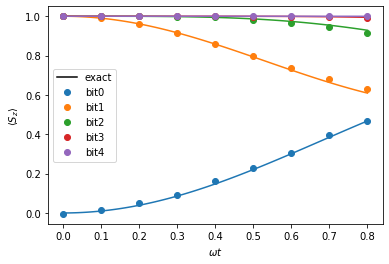

In [8]:
# Construct the numerical Hamiltonian matrix from a list of Pauli operators
paulis = list()
for j in range(num_sites - 1):
    paulis.append(list('x' if k in (j, j + 1) else 'i' for k in range(num_sites)))
    paulis.append(list('y' if k in (j, j + 1) else 'i' for k in range(num_sites)))            
    paulis.append(list('z' if k in (j, j + 1) else 'i' for k in range(num_sites)))

hamiltonian = make_hamiltonian(paulis)

# Express the initial state as a state vector
initial_state = np.zeros(2 ** num_sites, dtype=np.complex128)
initial_state[0:2] = np.sqrt(0.5)

plot_spins(sim_counts_list, num_sites, omegadt, hamiltonian=hamiltonian, initial_state=initial_state)

## Execute the circuits on an IBMQ device

In [9]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools import job_monitor

In [10]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [11]:
# IBMQ provider manages access to various backends
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# Filter function to choose an operational real-device backend with at least two qubits
def backend_filter(backend):
    config = backend.configuration()
    status = backend.status()
    return (not config.simulator) and (config.n_qubits >= 5) and status.operational

# List of backends satisfying the requirement
available_backends = provider.backends(filters=backend_filter)

# Choose the least busy backend among the available ones
backend = least_busy(available_backends)

print('Jobs will run on', backend.name())

Jobs will run on ibmq_lima


In [12]:
ibmq_circuits = transpile(circuits, backend=backend)
ibmq_job = backend.run(ibmq_circuits, shots=10000)
job_monitor(ibmq_job)

Job Status: job has successfully run


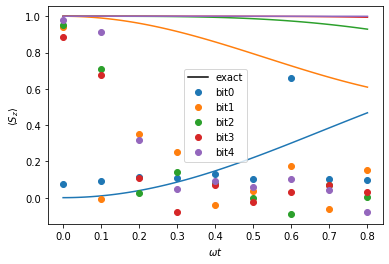

In [13]:
counts_list = ibmq_job.result().get_counts()
plot_spins(counts_list, num_sites, omegadt, hamiltonian=hamiltonian, initial_state=initial_state)